In [2]:
!cat /proc/meminfo | grep Mem
import psutil
psutil.virtual_memory()

MemTotal:       32940792 kB
MemFree:        29404848 kB
MemAvailable:   29946112 kB


svmem(total=33731371008, available=30664572928, percent=9.1, used=2434072576, free=30109999104, active=2288644096, inactive=739049472, buffers=1064960, cached=1186234368, shared=87789568, slab=166211584)

In [3]:
# gen libs
import xarray as xr
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import time

# libs for poincaré
from osa import Client

# emc3 submodule
import xemc3

#vtk libs
from tvtk.api import tvtk
from mayavi.scripts import mayavi2
from PyQt5 import QtCore
import sip
import vtk
from mayavi import mlab
%gui qt

# importing widget libs to make interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import os
import sys
psutil.virtual_memory()
cwd = os.getcwd()

In [4]:
#import the necessary functions from the previous scripts
loc_path_interpol_script = r"~/w7x"
fps = []
fps.append(loc_path_interpol_script + r"\grid.py")
fps.append(loc_path_interpol_script + r"\makemesh_indices.py")
for path in fps:
    module_path = os.path.abspath(os.path.join(path))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [5]:
from grid import grid
from makemesh_indices import make_parammesh_vtk_indices, from_indices_to_paramvals

In [6]:
path_timeseriesdata_emc3 = r"~/Dokumente/N01.nc"
ds_tot = xr.open_dataset(path_timeseriesdata_emc3)
psutil.virtual_memory()

svmem(total=33731371008, available=30492057600, percent=9.6, used=2603708416, free=29692964864, active=2452684800, inactive=978706432, buffers=1064960, cached=1433632768, shared=87793664, slab=172810240)

In [7]:
ds_tsdata_emc3 = ds_tot.isel(time = slice(-20,None))
del ds_tot
psutil.virtual_memory()

svmem(total=33731371008, available=30489632768, percent=9.6, used=2606129152, free=29689950208, active=2452807680, inactive=979255296, buffers=1064960, cached=1434226688, shared=87793664, slab=172920832)

In [ ]:
grid_512 = grid(ds = ds_tsdata_emc3, ngrid_cart = 400, inc_r = [50, 140], inc_t = [0,513], inc_p = [0,36])
dimgrid = list([x for x in grid_512.tor_x.shape[::-1]])
sgrid_512 = tvtk.StructuredGrid(dimensions=dimgrid)
del dimgrid
sgrid_512.points = grid_512.torflat
psutil.virtual_memory()

In [ ]:
idxmesh, weightmesh = make_parammesh_vtk_indices(grid_obj = grid_512, 
                                                 sgrid = sgrid_512, 
                                                 sp = (0,0,0), 
                                                 tolsqrd = 5e-2)

In [ ]:
del sgrid_512
with open('%s/timeseriesdata/idxmesh_%i.npy'%(cwd,idxmesh.shape[0]), 'wb') as f_i:
    np.save(f_i, idxmesh)
f_i.close()
del idxmesh

In [ ]:
with open('%s/timeseriesdata/weightmesh_%i.npy'%(cwd,weightmesh.shape[0]), 'wb') as f_w:
    np.save(f_w, weightmesh)
f_w.close()
del weightmesh

In [8]:
with open('%s/timeseriesdata/idxmesh_400.npy'%cwd, 'rb') as f_i:
    idxmesh_load = np.load(f_i)
f_i.close()
with open('%s/timeseriesdata/weightmesh_400.npy'%cwd, 'rb') as f_w:
    weightmesh_load = np.load(f_w)
f_w.close()

psutil.virtual_memory()

KeyboardInterrupt: 

In [9]:
def make_timeseries_data(idxs, weights, ds_param, sp = (0,0,0), str_size = '512'):
    for i in range(ds_param.shape[0]):
        ts = from_indices_to_paramvals(idxs = idxs,
                                       weights = weights,
                                       param_torgrid = np.asarray(ds_param[i]) )
        with open('%s/timeseriesdata/ts_'%cwd+str_size+'_%s.npy'%i, 'wb') as f_ts:
            np.save(f_ts, ts)
        del ts
        f_ts.close()

In [10]:
make_timeseries_data(idxs = idxmesh_load, 
                     weights = weightmesh_load, 
                     ds_param = ds_tsdata_emc3.Te[:,50:], 
                     sp = (0,0,0), str_size = '400')

NameError: name 'weightmesh_load' is not defined

In [11]:
with open('%s/timeseriesdata/ts_400_0.npy'%cwd, 'rb') as f_ts:
    t0 = np.load(f_ts)

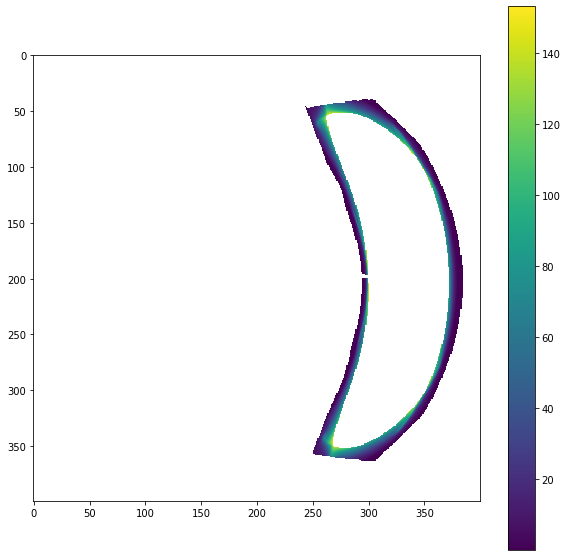

In [16]:
plt.figure(figsize = (10,10))
plt.imshow(t0[:,2].T[::-1])
plt.colorbar()

In [17]:
mean_sel = ds_tsdata_emc3.mean(dim = 'time')
psutil.virtual_memory()

KeyboardInterrupt: 

In [18]:
psutil.virtual_memory()

svmem(total=33731371008, available=26015731712, percent=22.9, used=7076880384, free=20057833472, active=6915485696, inactive=6127538176, buffers=1064960, cached=6595592192, shared=85057536, slab=184623104)

In [ ]:
#std_sel = ds_tsdata_emc3.std(dim = 'time')

In [ ]:
#std_tot = ds_tsdata_emc3.std()

In [ ]:
import clientdata

In [19]:
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import skimage.data
psutil.virtual_memory()

svmem(total=33731371008, available=25991090176, percent=22.9, used=7099035648, free=20002988032, active=6933598208, inactive=6157918208, buffers=1064960, cached=6628282368, shared=86814720, slab=186388480)

In [20]:
pmesh_ts = []
for i in range(20):
    with open('%s/timeseriesdata/ts_400_%i.npy'%(cwd,i), 'rb') as f_ts:
    #with open('/home/IPP-HGW/joag/Dokumente/earlier_timeseriesdata/ts_256_%i.npy'%i, 'rb') as f_ts:
        pmesh_ts.append(np.load(f_ts))
psutil.virtual_memory()

svmem(total=33731371008, available=15720476672, percent=53.4, used=17358548992, free=343519232, active=17920040960, inactive=14786863104, buffers=1064960, cached=16028237824, shared=86818816, slab=208646144)

In [21]:
def shiftinv_wavelet_denoising(tsdata, int_y = [0,pmesh_ts[0][0].shape[1]]):
    """
    Args:
     - tsdata, list of ndarray np.float64 (nt,)(nr,)(ix, iy, iz), list of times of list of regions of parameter mesh
     - int_phi, list of int, defining the interval in phi direction
    Out:
    """
    tik = time.time()
    denoised_t = []
    for t in range(len(tsdata)):
        img = tsdata[t].T[::-1,int_y[0]:int_y[1]].copy()
        imgisnan = np.isnan(img)
        img[imgisnan] = np.zeros(img[imgisnan].shape)
        # multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
        # denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
        denoised = cycle_spin(img, func=denoise_wavelet, max_shifts=(4,4,4))#max_shifts=img.shape
        # set values that were nan before the denoising back to nan
        denoised[imgisnan] = np.ones(denoised[imgisnan].shape)*np.nan
        denoised_t.append(denoised)
    tok = time.time()
    return denoised_t, tok-tik

In [22]:
emc3_denoised, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_ts)

/home/IPP-HGW/joag/.local/lib/python3.6/site-packages/skimage/restoration/_cycle_spin.py:124: FutureWarning: As of scikit-image 0.16, automated rescaling of sigma to match any internal rescaling of the image is performed. Setting rescale_sigma to False, will disable this new behaviour. To avoid this warning the user should explicitly set rescale_sigma to True or False.
  tmp = func(xs, **func_kw)


MemoryError: Unable to allocate 244. MiB for an array with shape (200, 400, 400) and data type float64

In [ ]:
print(runtime)
print(len(emc3_denoised))
emc3_denoised[0].shape

In [ ]:
plt.imshow(emc3_denoised[0][:,30])

In [ ]:
def compare_regplot(ogimg, denoised_img):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))
    noisy = ax[0,0].imshow(ogimg)
    ax[0,0].set_title("Noisy")
    fig.colorbar(noisy, ax = ax[0,0])
    denoised = ax[0,1].imshow(denoised_img)
    ax[0,1].set_title("Denoised")
    fig.colorbar(denoised, ax = ax[0,1])
    noise = ax[1,0].imshow(ogimg - denoised_img)
    ax[1,0].set_title("Noise")
    fig.colorbar(noise, ax = ax[1,0])

# Updated plan:
1. Compare filtering on whole dataset with effect of removing noise extracted from subtracting the mean from the dataset. Also compare the std and try to find other statistics to analyze the effect of the filter.
2. Quantify/Identify the effect of the interpolation with regards to noise by using synthetic data where noise could be easily subtracted from the cartesian data after being added to the emc3-like data. The synthetic data should be set up as cos functions varying in several directions for theta and phi, and have som radial dependence.
3. Do a spline fit in the toroidal direction for all parameter values centered at each cell. Compare with the current interpolation scheme?
4. 

# Conservation of physical quantities

1. Formulate the equations for the particle and heat flux balance.
2. Implement the conservation equations.
3. Confirm that the interpolation is conservation preserving.
4. Quantify the error of conservation introduced by the interpolation?

# The effect of noise with regards to the conservation of physical quantites
1. Add independent noiseterms to each terms of the conservation equations and see how it affects the interpolated data.
2. Apply the filtering to mean data + known noise terms to quantify the effect of the filtering method.
3. Try and quantify when the conservation laws break down by increasing the noise contribution.
4. Quantize the effect of the filtering method wiht regards to the conservation laws. How much does the filtering method increase the threshold of the noise contribution with regards to the preservation of conservation laws.

# Decomposing the drift terms
1. Formulate the equations of the drift terms.
2. Split drift terms into divergence-free and non-divergence-free terms.
3. Analyze the magnitude of the divergence-free terms. Give relative contribution measures to the $\mathbf{E}\times\mathbf{B}$-terms.
4. Give an analysis on whether to implement a divergence-free optimized interpolation scheme or not. If yes, go to the last step.

# Implementing divergence-free property of interpolation scheme
1. Generate synthetic divergence free field.
2. Implement method for checking diverge-free property of the field.
3. Investigate the effect that noise contribution has to the divergence-free property of the field and apply the filtering method on the synthetic field to give a measure on how the filtering method improves the preservation of the divergence-free property.
4. By using the synthetic divergence-free field, implement a divergence-free interpolation method or optimize the already implemented method.
5. Apply the divergence free interpolation on the raw emc3 data and confirm the divergence-free property of the relevant terms.
6. Apply the filtering method and repeat step 5.
7. Quantize the effect of the filter by comparing to the mean of the time series data.
8. Do a bootstrap of the standard deviation to give a measure on the accuracy of the mean, and finally do a bias corrected estimate?

# Particle conservation

## Generalized particle flux density conservation

\begin{equation}
    \nabla (n v) = S_p
\end{equation}

where the particle source term $S_p$ is set to zero because it will only be non-zero in proximity of the targets. $n$ and $v$ is the particle density and fluid velocity so the resulting conservation equation is:
\begin{equation}
\nabla(nv) = 0
\end{equation}

\begin{equation}
\Gamma = -D \frac{d n}{d \mathbf{r}}
\end{equation}

# Heat flux

\begin{align}
q_{\parallel} = -\chi_n\frac{dT_e}{d\mathbf{r}}
q_{\perp} = K_eT_e^{5/2}\frac{dT}{d\mathbf{r}}
\end{align}

In [ ]:
# note M is the mach number of the parallell number
mean_sel

In [ ]:
# plt.figure(figsize=(20,20))
# mean_sel.emc3.plot_Rz('fort.46_0', phi = 0)
gridlist_timeseries

In [ ]:
def get_magneticfield(grid_obj):
    """
    Args:
     - grid_obj, grid object
    Out:
     - Bmesh, ndarray np.float64, meshgrid of the magnetic field components
    """
    config = tracer.types.MagneticConfig()
    config.configIds = [0]

    pos = tracer.types.Points3D()
    pos.x1 = grid_obj.cartflat[:,0]
    pos.x2 = grid_obj.cartflat[:,1]
    pos.x3 = grid_obj.cartflat[:,2]

    res = tracer.service.magneticField(pos, config)
    B = np.zeros((3,) + pos.x1.shape)
    B[0] = np.asarray(res.field.x1)
    B[1] = np.asarray(res.field.x2)
    B[2] = np.asarray(res.field.x3)
#     print(B.shape)
#     idx_othreshold = np.where( np.median(np.sqrt(np.sum(B**2, axis = 0)) ) < np.sqrt(np.sum(B**2, axis = 0)) )[0]
#     print(np.sqrt(np.sum(B**2, axis = 0)).shape)
#     idx_othreshold = np.where( np.sqrt(np.sum(B**2, axis = 0)) > 5 )[0]
#     print(idx_othreshold.shape)
#     B[:,idx_othreshold] = np.ones(B[:,idx_othreshold].shape)*np.nan
    Bmesh = B.reshape((3,) + (grid_obj.cart_x.shape))
    return Bmesh

In [ ]:
_ = get_magneticfield(grid_obj = gridlist_timeseries[0])

In [ ]:
bmeshreg = []
for i in range(len(gridlist_timeseries)):
    bmeshreg.append( get_magneticfield(grid_obj = gridlist_timeseries[i]) )

In [ ]:
len(bmeshreg)
bmeshreg

In [ ]:
mlab.clf()
mlab.quiver3d(gridlist_timeseries[0].cart_x, 
              gridlist_timeseries[0].cart_y, 
              gridlist_timeseries[0].cart_z, 
              bmeshreg[4][0], bmeshreg[4][1], bmeshreg[4][2])
mlab.axes()
mlab.scalarbar()
mlab.outline()

In [ ]:
def proj_gradparam_ontob(parammesh, b):
    """
    Args:
    - parammesh, ndarray np.float64, cart coord, assuming scalar field
    - b, ndarray np.float64, cart coord, magnetic unit vectors
    Out:
    - proj, ndarray np.float64, cart coord, the projection of the gradient onto the magnetic unit vectors
    """
    grad = np.gradient(parammesh)
    grad = np.array(grad)
    print(grad.shape)
    print(b.shape)
    proj = np.nansum(grad*b, axis = 0)*b
    return proj

def decompose_parperp(parammesh, b):
    """
    Args:
    - parammesh, ndarray np.float64, cart coord, assuming parammesh a scalar field
    Out:
    - paral, perp, ndarray np.float64, fieldline coords, 
      decomposed parallel and perpendicular comp of parammesh
    """
    grad = np.gradient(parammesh)
    paral = proj_gradparam_ontob(parammesh = parammesh, b = b)
    perp = grad - paral
    return paral, perp

def calc_divergence(parammesh):
    """
    Args:
    - parammesh, ndarray np.float64, cart coords, assuming vector field
    Out:
    - divergence of the vector field
    """
    divcomp = [np.gradient(parammesh[i])[i] for i in range(3)]
    return sum(divcomp) #Q: should I use nansum here??

In [ ]:
pmesh_ts[0][0].shape
bmeshreg[0].shape

In [ ]:
projtest = proj_gradparam_ontob(parammesh = pmesh_ts[0][0], b = bmeshreg[0])

In [ ]:
projtest.shape

In [ ]:
mlab.clf()
mlab.quiver3d(gridlist_timeseries[0].cart_x, 
              gridlist_timeseries[0].cart_y, 
              gridlist_timeseries[0].cart_z, 
              projtest[0], projtest[1], projtest[2])
mlab.axes()
mlab.scalarbar()
mlab.outline()

In [ ]:
import scipy.constants
def calc_electron_vel(machnumber, Te, Ti, m_i = scipy.constants.m_p):
    return machnumber*np.sqrt((Te + Ti)/m_i)    

In [ ]:
# here the interpolated values for M, Te and Ti shoudl be inserted instead of the means of the w7x griddata
el_vel = calc_electron_vel(machnumber = mean_sel.M, Te = mean_sel.Te, Ti = mean_sel.Ti)

In [ ]:
"""
Define a function(if necessary) that takes in electron velocity and electron density and calculates the
gradient \nabla(nv) which should be zero
"""